##Objective :

The objective of this project is to analyze team-level performance metrics in the EuroLeague in order to identify which aspects are most strongly associated with season-long success so total number of wins.

Data is collected from different euroleague seasons (2021-2025). With this data, project aims to explore the relationships between offensive, defensive and efficiency-based statistics and team success. The analysis begins with the exploratory data analysis (EDA), followed by formal hypothesis testing to evaluate the statistical significance of observed relationships.


##Codes for Uploading and Organising the Data:

In [ ]:
#Uploading seaons stats csv files:

import pandas as pd

df_21_22 = pd.read_csv("2021_2022_stats.csv")
df_22_23 = pd.read_csv("2022_2023_stats.csv")
df_23_24 = pd.read_csv("2023_2024_stats.csv")
df_24_25 = pd.read_csv("2024_2025_stats.csv")

#Labeling the data for convenience:

df_21_22["season"] = "2021-2022"
df_22_23["season"] = "2022-2023"
df_23_24["season"] = "2023-2024"
df_24_25["season"] = "2024-2025"

#Combining all data:

df = pd.concat(
    [df_21_22, df_22_23, df_23_24, df_24_25],
    ignore_index=True
)

#How many outputs for each season:
df["season"].value_counts()


,count
season,
2021-2022,18
2022-2023,18
2023-2024,18
2024-2025,18


##Beginning of the EDA:
This histogram illustrates the distribution of total wins (W) across all team-season observations included in the dataset. Examining the distribution of the target variable provides insight into the overall competitiveness of the league and helps identify potential skewness or outliers.

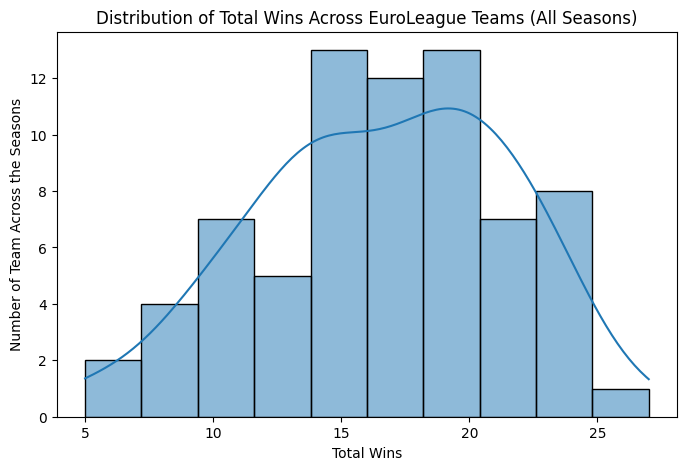

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["W"], bins=10, kde=True)
plt.title("Distribution of Total Wins Across EuroLeague Teams (All Seasons)")
plt.xlabel("Total Wins")
plt.ylabel("Number of Team Across the Seasons")
plt.show()

In this step, correlation analysis is used to identify the team performance metrics that are most strongly associated with total wins (W). Based on the magnitude of the correlation coefficients, the most relevant metrics are selected, and the top five features are further examined using scatter plots to visually assess their relationships with team success. These observations guide the subsequent hypothesis testing stage.

In [ ]:
#Correlation of other variables with the Win(W) variable, and selecting the 5 most related metrics/features. 

numeric = df.select_dtypes(include="number")

#Subtracting the mostly correlated matrices that are Loose and Win
leak_cols = ["L" , "W"]
leak_cols = [c for c in leak_cols if c in numeric.columns]

corr_with_w = (
    numeric.drop(columns=leak_cols, errors="ignore")
          .corrwith(numeric["W"])
          .abs()
          .sort_values(ascending=False)
)

top_features = corr_with_w.head(5).index.tolist()
top_features

['PTS', '3PM', 'FGM', 'DRB', 'FTM']

## Hypothesis Testing

For each selected metric, we test whether its correlation with total wins (W) is statistically significant.

- H0: There is no correlation between the metric and total wins (ρ = 0).
- H1: There is a non-zero correlation between the metric and total wins (ρ ≠ 0).

We report Pearson correlation coefficients and p-values. To control for multiple comparisons across several metrics, we additionally apply FDR correction.

In [25]:
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

results = []

for feat in top_features:
    x = df[feat]
    y = df["W"]
    valid = x.notna() & y.notna()
    r, p = pearsonr(x[valid], y[valid])
    results.append({"metric": feat, "pearson_r": r, "p_value": p, "n": int(valid.sum())})

res_df = pd.DataFrame(results).sort_values("p_value")
res_df
pvals = res_df["p_value"].values
_, p_adj, _, _ = multipletests(pvals, method="fdr_bh")

res_df["p_value_fdr"] = p_adj
res_df["significant_fdr_0.05"] = res_df["p_value_fdr"] < 0.05
res_df.index = range(1, len(res_df) + 1)

res_df


,metric,pearson_r,p_value,n,p_value_fdr,significant_fdr_0.05
1,PTS,0.454852,0.000060,72,0.000298,True
2,3PM,0.409445,0.000355,72,0.000722,True
3,FGM,0.403962,0.000433,72,0.000722,True
4,DRB,0.369223,0.001414,72,0.001747,True
5,FTM,0.362601,0.001747,72,0.001747,True


## Results and Interpretation

The hypothesis testing results reveal that all five selected team performance metrics are statistically significantly correlated with total wins (W) after controlling for multiple comparisons using FDR correction (q < 0.05). Among these metrics, total points scored (PTS) exhibits the strongest association with team success (r ≈ 0.45), followed by three-point makes (3PM) and field goals made (FGM), highlighting the importance of offensive production in determining season-long outcomes.

Additionally, defensive rebounds (DRB) and free throws made (FTM) also show moderate but statistically significant positive correlations with wins, suggesting that possession control and scoring efficiency at the free-throw line contribute meaningfully to overall team performance. Together, these findings indicate that successful EuroLeague teams tend to combine offensive efficiency with effective rebounding and consistent scoring opportunities, providing an evidence-based foundation for subsequent predictive modeling.

##Visualization of Results of the Hypothesis Test:
The bar plot summarizes the strength and statistical significance of the correlations between selected performance metrics and total wins (W). Metrics highlighted as significant remain statistically meaningful after FDR correction, providing a visual complement to the hypothesis testing results.

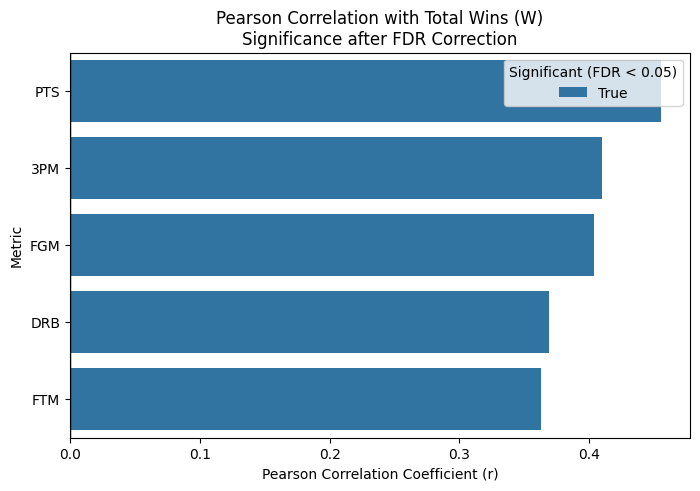

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(
    data=res_df,
    x="pearson_r",
    y="metric",
    hue="significant_fdr_0.05",
    dodge=False
)

plt.axvline(0, color="black", linewidth=1)
plt.title("Pearson Correlation with Total Wins (W)\nSignificance after FDR Correction")
plt.xlabel("Pearson Correlation Coefficient (r)")
plt.ylabel("Metric")
plt.legend(title="Significant (FDR < 0.05)")
plt.show()
